<a href="https://colab.research.google.com/github/timothy-voiuhy/WasteClassification/blob/main/WasteClassificationv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
# some necessary imports
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import torch.nn as nn
import seaborn as sns
from torch.utils.data import random_split,  Dataset, DataLoader
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import os
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import shutil
import os

In [ ]:
# download the waste data.
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
100% 916M/920M [00:35<00:00, 22.0MB/s]
100% 920M/920M [00:35<00:00, 27.3MB/s]


In [ ]:
# !unzip recyclable-and-household-waste-classification.zip
!ls images/images

aerosol_cans		    glass_beverage_bottles     plastic_shopping_bags
aluminum_food_cans	    glass_cosmetic_containers  plastic_soda_bottles
aluminum_soda_cans	    glass_food_jars	       plastic_straws
cardboard_boxes		    magazines		       plastic_trash_bags
cardboard_packaging	    newspaper		       plastic_water_bottles
clothing		    office_paper	       shoes
coffee_grounds		    paper_cups		       steel_food_cans
disposable_plastic_cutlery  plastic_cup_lids	       styrofoam_cups
eggshells		    plastic_detergent_bottles  styrofoam_food_containers
food_waste		    plastic_food_containers    tea_bags


In [116]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR_PATH = "images/images/"
bestModelPath = "/content/drive/MyDrive/Models/WasteClfBest.pt"
bestModelPathC = "/content/drive/MyDrive/Models/WasteClfBest0.pt"
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 4

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
odd_nums = [num for num in range(1, 501) if num % 2 != 0]
even_nums = [num for num in range(1, 501) if num%2 == 0]
def MergeData():
    dirs = []
    for __dir_name in os.listdir(DATA_DIR_PATH):
        dirs.append(os.path.join(DATA_DIR_PATH, __dir_name))
    for __dir in dirs:
        default_dir = __dir+"/default"
        real_world_dir = __dir+"/real_world"
        for __d_filename, __r_filename, __e, __o in zip(os.listdir(default_dir), os.listdir(real_world_dir), even_nums, odd_nums):
            _d__filename = os.path.join(__dir, __d_filename.split("_")[0]+"_"+str(__o)+".png")
            _r__filename = os.path.join(__dir, __r_filename.split("_")[0]+"_"+str(__e)+".png")
            shutil.move(os.path.join(default_dir, __d_filename),_d__filename)
            shutil.move(os.path.join(real_world_dir, __r_filename),_r__filename)
        os.rmdir(default_dir)
        os.rmdir(real_world_dir)
MergeData()

In [ ]:
def reorganize_directories(base_dir):
    # Define the class mappings
    class_mapping = {
        "metal": [
            "aluminum_food_cans", "aluminum_soda_cans", "steel_food_cans", "aerosol_cans"
        ],
        "organic": [
            "coffee_grounds", "eggshells", "food_waste", "tea_bags",
            "cardboard_boxes", "cardboard_packaging", "clothing", "magazines",
            "newspaper", "office_paper", "paper_cups", "shoes"
        ],
        "plastic": [
            "plastic_shopping_bags", "plastic_soda_bottles", "plastic_straws",
            "plastic_trash_bags", "plastic_water_bottles", "disposable_plastic_cutlery",
            "plastic_cup_lids", "plastic_detergent_bottles", "plastic_food_containers",
            "styrofoam_cups", "styrofoam_food_containers"
        ],
        "glass": [
            "glass_beverage_bottles", "glass_cosmetic_containers", "glass_food_jars"
        ]
    }

    # Create directories for each class
    for category in class_mapping:
        category_path = os.path.join(base_dir, category)
        os.makedirs(category_path, exist_ok=True)

    # Move directories into respective classes
    for category, dirs in class_mapping.items():
        for dir_name in dirs:
            src_path = os.path.join(base_dir, dir_name)
            dst_path = os.path.join(base_dir, category, dir_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)

reorganize_directories(DATA_DIR_PATH)


In [ ]:
transform = v2.Compose([
    v2.Resize(IMAGE_SIZE),
])

train_transform = v2.Compose([
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
    v2.ToTensor(),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

val_test_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = ImageFolder(
    root = DATA_DIR_PATH,
    transform = transform
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
class CDataset(Dataset):
    def __init__(self, _dataset, transform_:v2.Compose, classes) -> None:
        super().__init__()
        self.dataset = _dataset
        self.transform = transform_
        self.classes = classes

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return image, label

    def __len__(self,):
        return len(self.dataset)

In [ ]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
validation_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - validation_size

_train_dataset, _validation_dataset, _test_dataset = random_split(dataset, [train_size, validation_size, test_size])

train_dataset = CDataset(_train_dataset, train_transform, dataset.classes)
validation_dataset = CDataset(_validation_dataset, val_test_transform, dataset.classes)
test_dataset = CDataset(_test_dataset, val_test_transform, dataset.classes)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(validation_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 10500
Validation size: 2250
Test size: 2250


In [ ]:
train_dataloader = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2)

validation_dataloader = DataLoader(validation_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2)
test_dataloader = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2)

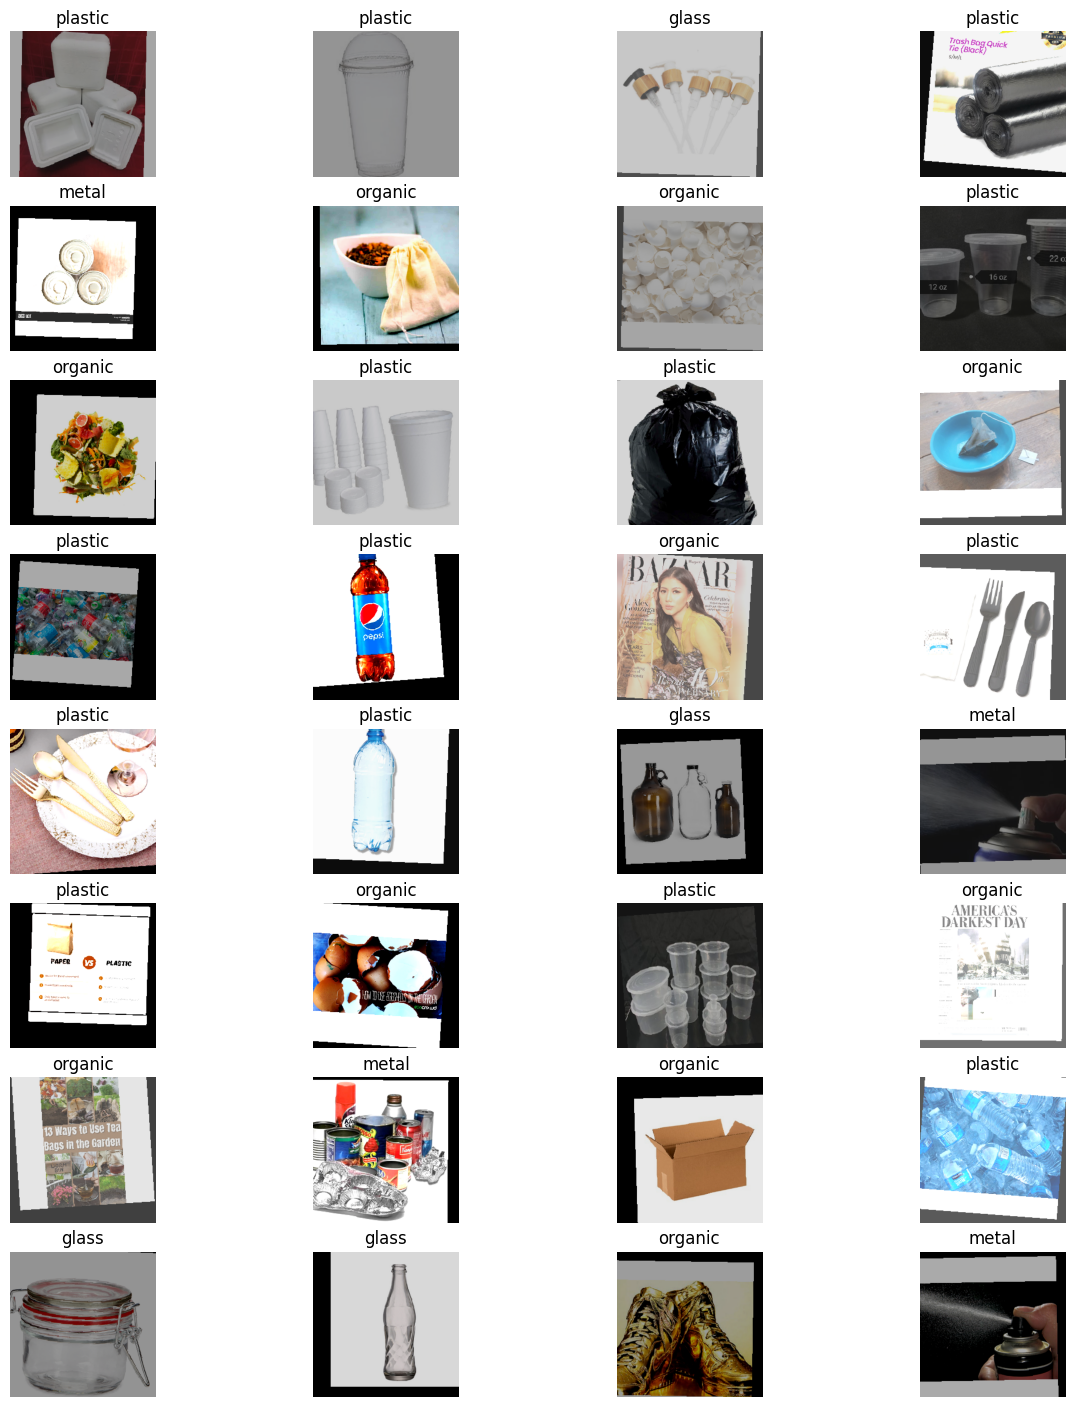

In [ ]:
images, labels = next(iter(train_dataloader))
class_names = train_dataset.classes
column_count = 4
row_count = len(images) // column_count + 1
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
plt.figure(figsize = (15, 20))
for idx, (image, label) in enumerate(zip(images, labels)):
    image  = image.cpu().numpy().transpose((1, 2, 0))
    image = std*image + mean
    plt.subplot(row_count, column_count, idx+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")

plt.show()

In [ ]:
base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
print(base_model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 64.0MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
class WasteClfModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        train_nodes, eval_nodes = get_graph_node_names(self.base_model)
        self.f_ext = create_feature_extractor(
            self.base_model,
            return_nodes={'features.12': 'base_model_ext_features'}
        )
        self.conv1 = nn.Conv2d(576,300,3)
        self.Linear1 = nn.Linear(10800,900)
        self.Linear2 = nn.Linear(900, NUM_CLASSES)
        self.drop_out = nn.Dropout()

    def forward(self,x):
        f_layer = self.f_ext(x)['base_model_ext_features'] # pass the inputs through the mobile net model but only extract out the features at the 12 block CNN
        x = F.relu(self.conv1(f_layer))
        x = x.flatten(start_dim=1)
        x = self.drop_out(x)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return x

In [ ]:
loss_fn = nn.CrossEntropyLoss()
model = WasteClfModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
clf_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)

In [ ]:
def computeLoss(model:WasteClfModel, images, labels, train = False):
    images, labels = images.to(device), labels.to(device)
    preds = model(images)
    loss = loss_fn(preds, labels)
    if train:
        loss.backward()
    acc = clf_accuracy(preds.cpu(), labels.cpu())
    if isinstance(loss, torch.Tensor):
        loss = loss.item()
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return loss, acc

def evaluateModel(model:WasteClfModel):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_acc = 0
        for idx, (images, labels) in enumerate(test_dataloader):
            loss, acc = computeLoss(model, images, labels)
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(test_dataloader)
        avg_acc = total_acc / len(test_dataloader)
        print(f"Test Loss: {avg_loss:.5f}, Test Acc: {avg_acc:.5f}")
    return avg_loss, avg_acc

def validateModel(model:WasteClfModel):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_acc = 0
        for idx, (images, labels) in enumerate(validation_dataloader):
            loss, acc = computeLoss(model, images, labels)
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(validation_dataloader)
        avg_acc = total_acc / len(validation_dataloader)
    return avg_loss, avg_acc

def trainModel(model:WasteClfModel, epochs = 1):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    min_loss_ = 1.1244753649536992
    for epoch in range(0, epochs):
        print(f"Epoch: {epoch}")
        model.train()
        epoch_total_loss = 0
        epoch_total_acc = 0
        for idx, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_loss, train_acc = computeLoss(model, images, labels, train = True)
            epoch_total_loss += train_loss
            epoch_total_acc += train_acc
            optimizer.step()

            if idx % 30 == 0:
                print(f"\tStep: {idx}/{len(train_dataloader)} Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")

        val_loss, val_acc = validateModel(model)

        train_loss = epoch_total_loss / len(train_dataloader)
        train_acc = epoch_total_acc / len(train_dataloader)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Train Acc: {train_acc:5f}, Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
        if val_loss < min_loss_:
            print(f"Model val_loss improved from {min_loss_} to {val_loss}")
            min_loss_ = val_loss
            torch.save(model.state_dict(), bestModelPath)
            print(f"Model Saved to file: {bestModelPath}")
        else:
            print(f"Model val_loss did not improve from {min_loss_}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
# now its time to write the training loop
history = trainModel(model, 30)

Epoch: 0
	Step: 0/329 Train Loss: 1.48028, Train Acc: 0.15625
	Step: 30/329 Train Loss: 1.27796, Train Acc: 0.56250
	Step: 60/329 Train Loss: 0.80682, Train Acc: 0.68750
	Step: 90/329 Train Loss: 1.00064, Train Acc: 0.62500
	Step: 120/329 Train Loss: 0.75048, Train Acc: 0.71875
	Step: 150/329 Train Loss: 0.52677, Train Acc: 0.81250
	Step: 180/329 Train Loss: 0.78824, Train Acc: 0.71875
	Step: 210/329 Train Loss: 0.74615, Train Acc: 0.62500
	Step: 240/329 Train Loss: 0.67371, Train Acc: 0.68750
	Step: 270/329 Train Loss: 0.68413, Train Acc: 0.78125
	Step: 300/329 Train Loss: 0.40874, Train Acc: 0.81250
Epoch: 0, Train Loss: 0.96820, Train Acc: 0.651216, Val Loss: 0.80890, Val Acc: 0.73688
Model val_loss improved from 1.1244753649536992 to 0.8088957499450361
Model Saved to file: /content/drive/MyDrive/Models/WasteClfBest.pt
Epoch: 1
	Step: 0/329 Train Loss: 0.94534, Train Acc: 0.68750
	Step: 30/329 Train Loss: 0.72389, Train Acc: 0.65625
	Step: 60/329 Train Loss: 0.66644, Train Acc: 0.81

In [ ]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = history

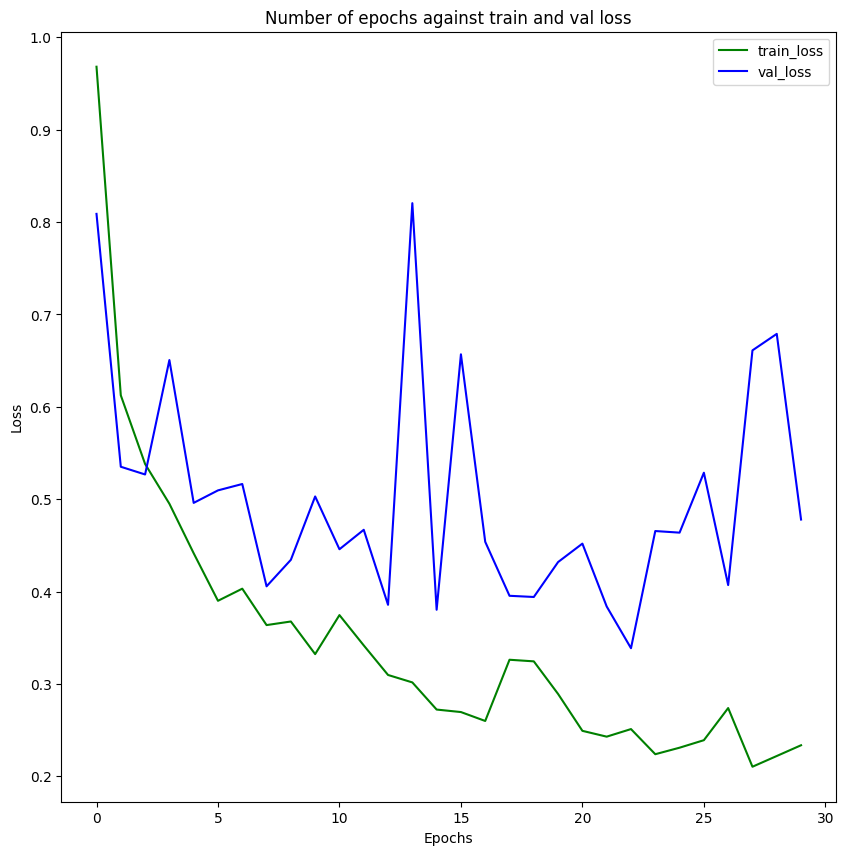

In [ ]:
n_epochs = range(0, len(train_loss_history))
plt.figure(figsize = (10, 10))
plt.plot(n_epochs, train_loss_history, label = "train_loss", c = "green")
plt.plot(n_epochs, val_loss_history, label = "val_loss", c = "blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Number of epochs against train and val loss")
plt.legend()

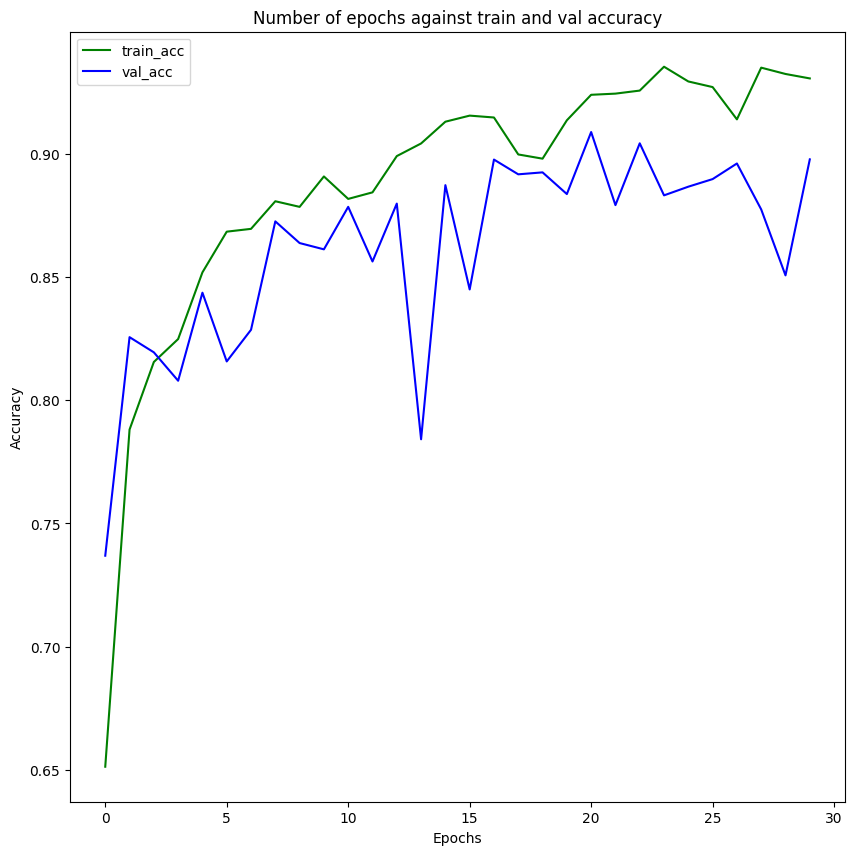

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(n_epochs, train_acc_history, label = "train_acc", c = "green")
plt.plot(n_epochs, val_acc_history, label = "val_acc", c = "blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Number of epochs against train and val accuracy")
plt.legend()

In [ ]:
evaluateModel(model)

Test Loss: 0.34698, Test Acc: 0.91417


(0.34698290345666877, 0.9141725352112676)

In [ ]:
torch.save(model.state_dict(), bestModelPathC)

In [ ]:
savedModel = WasteClfModel()
savedModel.load_state_dict(torch.load(bestModelPath))
savedModel.to(device)

<ipython-input-41-36f9da53908d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  savedModel.load_state_dict(torch.load(bestModelPath))


WasteClfModel(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2):

In [ ]:
y_preds, y_true = [], []

for idx, (images_, labels_) in enumerate(test_dataloader):
    images_, labels_ = images_.to(device), labels_.to(device)
    savedModel.eval()
    with torch.inference_mode():
        output = savedModel(images_)
        preds = torch.argmax(output,1)
        if idx == 0:
            print(preds)
        y_preds.extend(preds.cpu().numpy().tolist())
        y_true.extend(labels_.cpu().numpy().tolist())

tensor([0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 0, 3, 2, 2, 2, 3, 2, 2, 2, 3,
        0, 2, 2, 3, 0, 3, 3, 3], device='cuda:0')


In [ ]:
print(f"y_preds: {y_preds}")
print(f" y_true: {y_true}")

y_preds: [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 0, 3, 2, 2, 2, 3, 2, 2, 2, 3, 0, 2, 2, 3, 0, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 3, 0, 1, 3, 3, 3, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 3, 0, 1, 3, 3, 1, 3, 3, 2, 2, 3, 0, 3, 3, 2, 1, 2, 3, 2, 3, 3, 1, 3, 1, 0, 0, 3, 3, 3, 3, 3, 1, 0, 3, 1, 0, 2, 3, 2, 2, 1, 0, 3, 2, 1, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 0, 1, 2, 3, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 3, 3, 1, 3, 1, 2, 2, 0, 3, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 3, 1, 1, 2, 3, 2, 3, 0, 3, 3, 3, 3, 2, 2, 1, 0, 3, 1, 3, 2, 3, 2, 0, 2, 1, 0, 3, 3, 1, 2, 0, 1, 3, 2, 3, 3, 2, 2, 3, 2, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 2, 2, 3, 1, 1, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 3, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 2, 2, 3, 0, 3, 3, 0, 1, 2, 2, 1, 2, 2, 2, 3, 0, 2, 1, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 0, 1, 1, 3, 3, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 1, 3, 3, 2, 1, 1, 1, 2, 0, 2, 0, 3, 3, 3, 3, 2, 2, 3, 0, 2, 2, 3, 0, 1, 3, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 3, 2, 0, 3, 

In [ ]:
output.shape

torch.Size([32, 30])

In [ ]:
output.device

device(type='cuda', index=0)

In [ ]:
output = torch.argmax(output, dim=1)
output.shape

torch.Size([32])

In [ ]:
len(y_true), len(y_preds), len(class_names)

(2250, 2250, 4)

In [ ]:
print(classification_report(y_true, y_preds, target_names= class_names))

              precision    recall  f1-score   support

       glass       0.83      0.96      0.89       250
       metal       0.87      0.94      0.90       319
     organic       0.94      0.89      0.92       874
     plastic       0.91      0.88      0.90       807

    accuracy                           0.90      2250
   macro avg       0.89      0.92      0.90      2250
weighted avg       0.91      0.90      0.90      2250



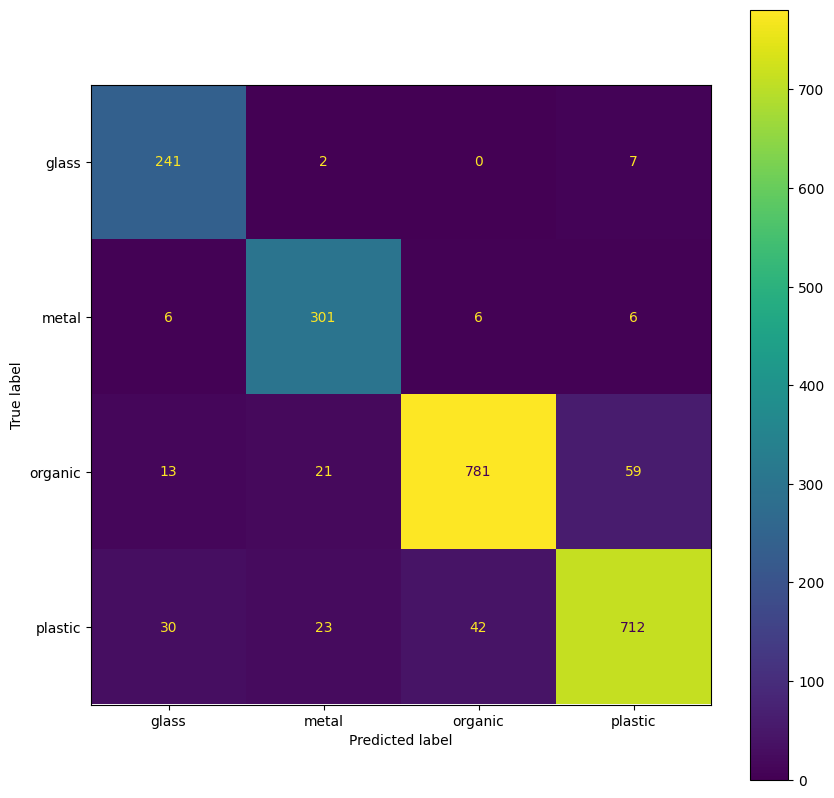

In [ ]:
cm = confusion_matrix(y_true, y_preds)
display_ = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, axes = plt.subplots(figsize=(10,10))
display_.plot(ax=axes)

In [ ]:
gradcam_test_images, gradcam_test_labels = next(iter(test_dataloader))
gradcam_test_pImages = [image.cpu() for image in gradcam_test_images]

In [ ]:
print(savedModel)

WasteClfModel(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2):

In [ ]:
# gradcam_test_image_ = gradcam_test_image.reshape((1, 3, 256, 256))
gradcam_test_pImages_ = torch.stack(gradcam_test_pImages)
gradcam_test_pImages_.shape, gradcam_test_labels.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [ ]:
# GRADCAM
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

gradcam = GradCAM(model=savedModel, target_layer=savedModel.conv1)
transform_ = v2.ToPILImage()

In [ ]:
sft = nn.Softmax(dim=1)

In [132]:
test_class_names = test_dataset.classes

def processGradCam(test_images, test_labels = None):
    heat_maps = []
    imgs = []
    confidences = []
    pred_names = []
    class_names = []
    for gradcam_test_image, gradcam_test_image_idx in zip(test_images, test_labels):
        gradcam_test_image_ = gradcam_test_image.unsqueeze(0)

        output = savedModel(gradcam_test_image_.to(device))

        conf = torch.max(sft(output), dim=1).values.item()
        confidences.append(conf)

        class_idx = gradcam_test_image_idx
        class_names.append(test_class_names[class_idx])
        pred_names.append(test_class_names[torch.argmax(output, 1)])

        cam_extractor = gradcam(class_idx.item(), output)
        cam = cam_extractor[0]

        cam_ = transform_(cam)
        img = transform_(gradcam_test_image)

        heat_maps.append(cam_)
        imgs.append(img)
    return heat_maps, imgs, confidences, pred_names, class_names

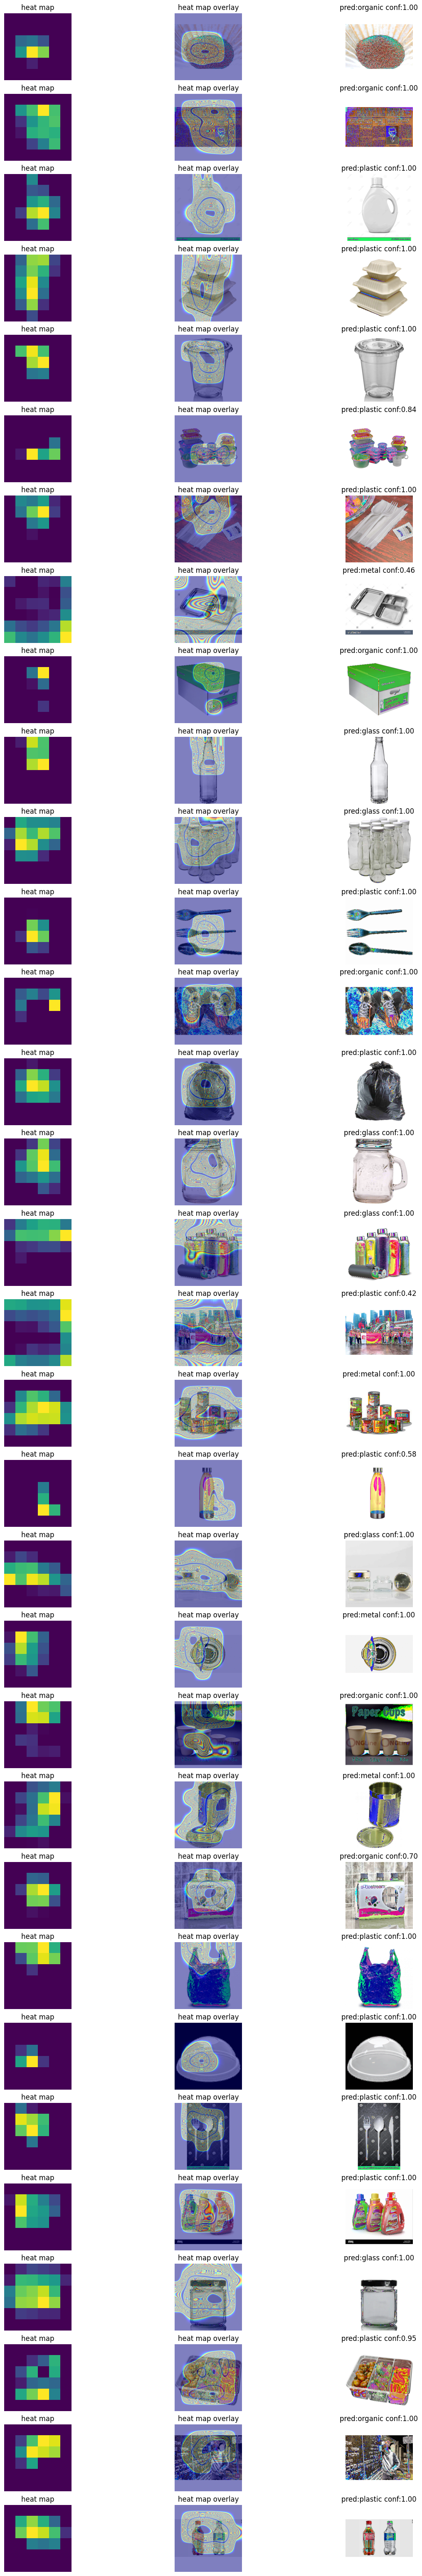

In [177]:
n_columns = 3
heat_maps, imgs, confidences, pred_names, class_names = processGradCam(gradcam_test_pImages, gradcam_test_labels)

def visualizeGradCams(figsize:tuple, heatmaps, ims, confs, pnames, cnames):
    plt.figure(figsize = figsize)
    n_rows = len(heat_maps)
    for idx, (heat_map, img, conf, p_name, c_name) in enumerate(zip(heatmaps, ims, confs, pnames, cnames)):
        plt.subplot(n_rows, n_columns, idx*n_columns+1)
        plt.imshow(heat_map)
        plt.title("heat map")
        plt.axis("off")
        plt.subplot(n_rows, n_columns, idx*n_columns+2)
        plt.imshow(overlay_mask(img, heat_map, alpha=0.5))
        plt.title("heat map overlay")
        plt.axis("off")
        plt.subplot(n_rows, n_columns, idx*n_columns+3)
        plt.imshow(img)
        plt.title(f"pred:{p_name} conf:{conf:.2f}")
        plt.axis("off")
    # plt.tight_layout()
    plt.show()

visualizeGradCams((15, 80),heat_maps, imgs, confidences, pred_names, class_names)

In [117]:
phone_taken_images_path = "/content/drive/MyDrive/Materialstest/"

In [118]:
!ls {phone_taken_images_path}

20241101_045710.jpg  20241101_071132.jpg  20241101_071227.jpg
20241101_045718.jpg  20241101_071141.jpg  20241101_071236.jpg
20241101_045731.jpg  20241101_071207.jpg  20241101_071254.jpg


In [119]:
from PIL import Image

In [172]:
image_paths = []
for __filename in os.listdir(phone_taken_images_path):
    image_paths.append(os.path.join(phone_taken_images_path, __filename))

pt_test_transform = v2.Compose([
    v2.Resize(IMAGE_SIZE),
    v2.ToTensor(),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

pt_grad_cam_images = []
pil_ims = []
for im_path in image_paths:
    img = Image.open(im_path)
    pil_ims.append(img)
    img = pt_test_transform(img)
    pt_grad_cam_images.append(img)
# pt_grad_cam_images = torch.stack(pt_grad_cam_images)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


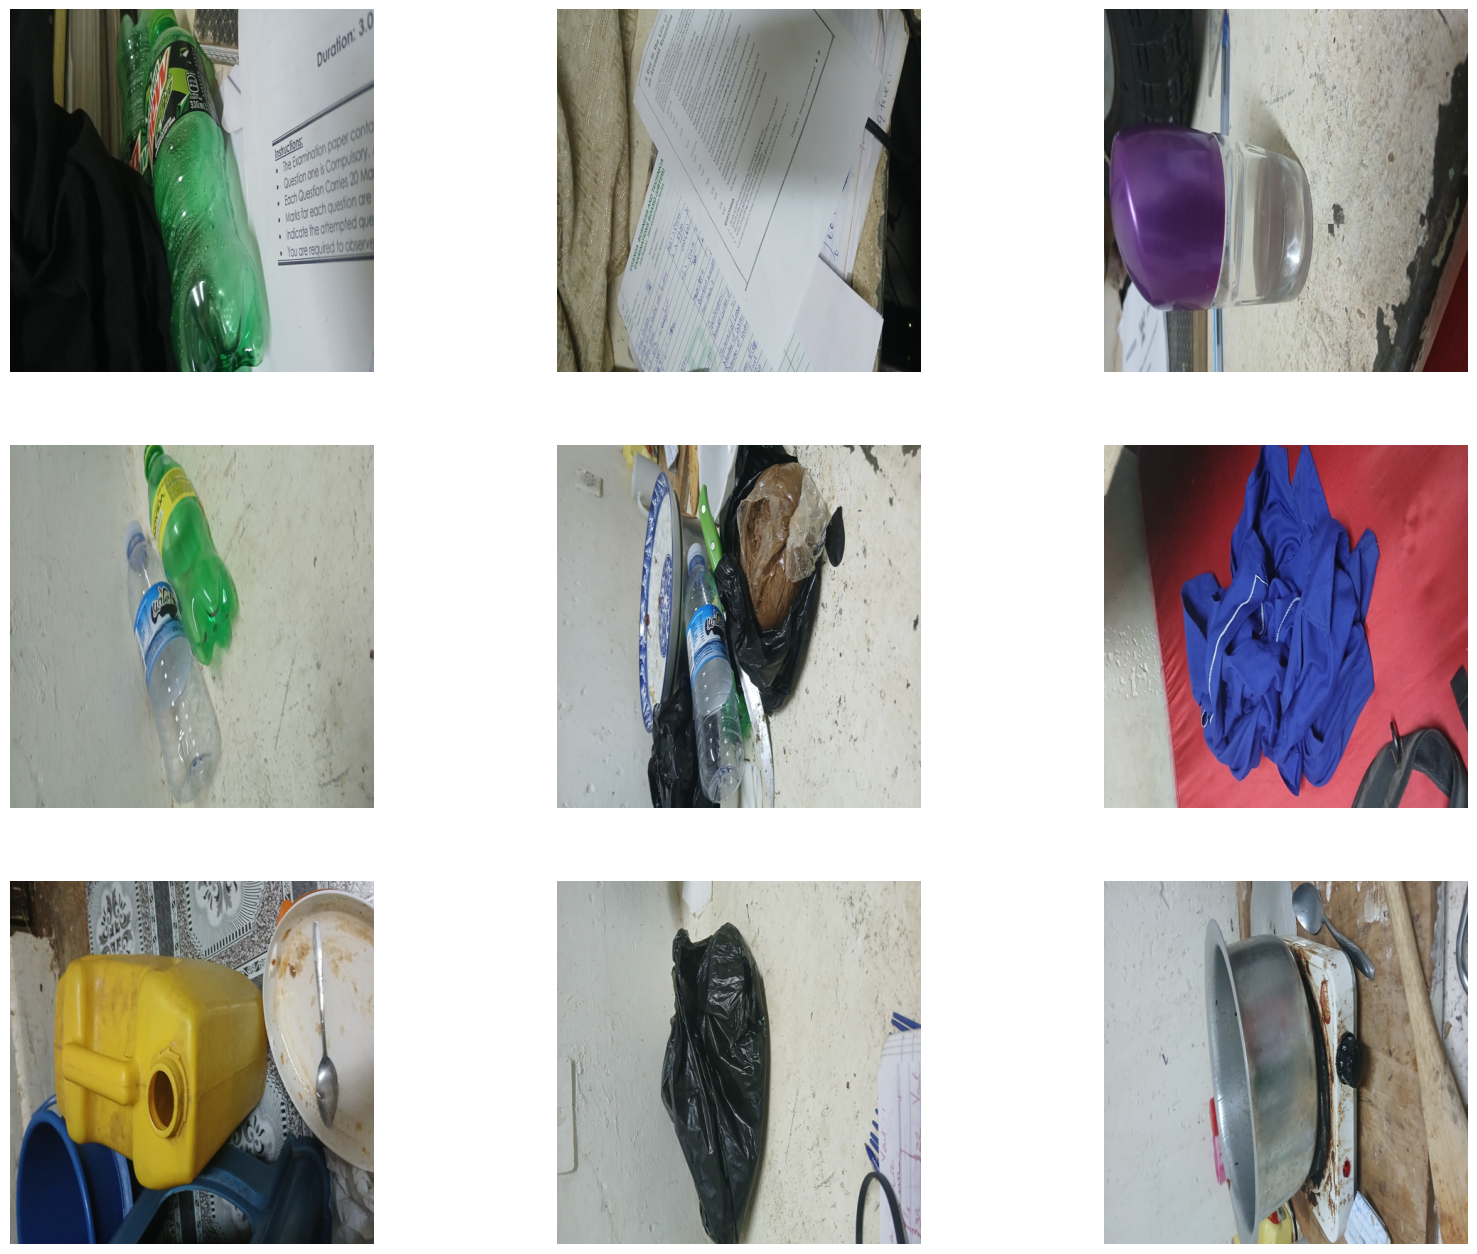

In [174]:
plt.figure(figsize = (20, 50))
n_columns = 3
for idx, image in enumerate(pil_ims):
    plt.subplot(9, 3, idx+1)
    image = image.resize((512, 512))
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [134]:
test_dataset.classes

['glass', 'metal', 'organic', 'plastic']

In [167]:
def denormalize_image(tensor, mean, std):
    """
    Reverses the normalization of a PyTorch tensor.

    Args:
        tensor (torch.Tensor): The normalized image tensor, expected to be in the format [C, H, W].
        mean (list of float): The mean values used for normalization for each channel.
        std (list of float): The std values used for normalization for each channel.

    Returns:
        torch.Tensor: The denormalized image tensor.
    """
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    denormalized_tensor = tensor * std + mean
    return denormalized_tensor


In [180]:
pt_labels = torch.tensor([3, 2, 0, 3, 3, 2, 3, 3, 1])
pt_names = [test_dataset.classes[label] for label in pt_labels]
pt_heat_maps_, pt_imgs_, pt_confidences, pt_pred_names, pt_class_names = processGradCam(pt_grad_cam_images, pt_labels)
pt_heat_maps, pt_imgs = [], []
t = v2.ToTensor()
for hm, im in zip(pt_heat_maps_, pt_imgs_): # make the images larger
    hm = t(hm) # to tensor for tensor calculations
    im = t(im)
    hm = transform_(hm) # back to PIL image
    im = transform_(im)
    pt_heat_maps.append(hm.resize((512, 512)))
    pt_imgs.append(im.resize((512, 512)))
n_columns = 3

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


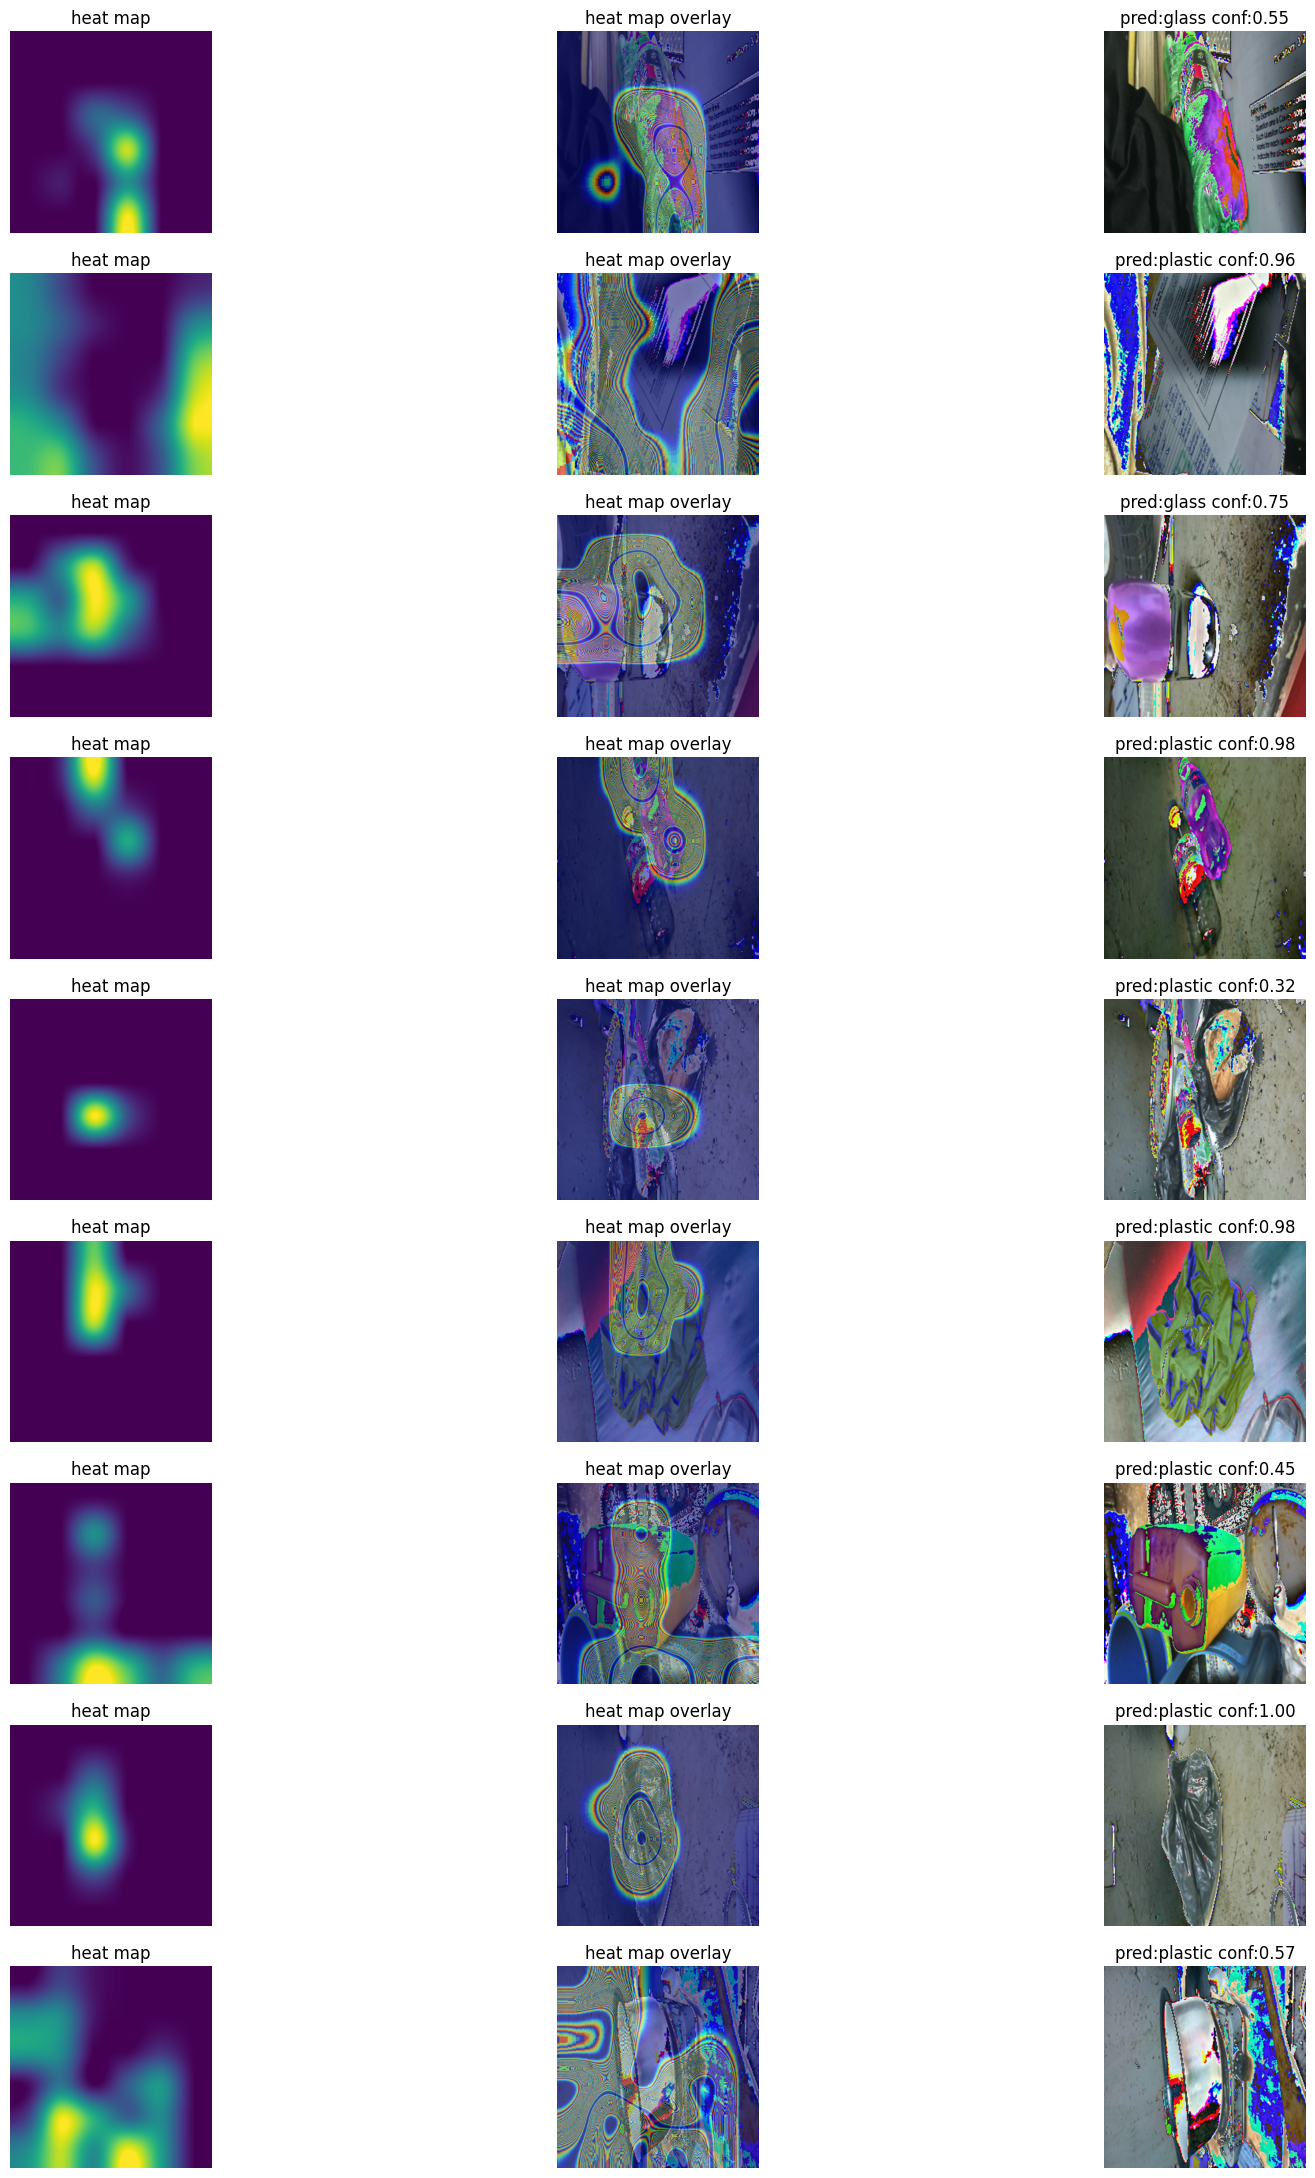

In [182]:
visualizeGradCams((20, 100), pt_heat_maps, pt_imgs, pt_confidences, pt_pred_names, pt_names)